# Análisis exploratorio y predicción de sentimientos en un ecommerce

## Introducción

Este notebook está basado en el dataset de Kaggle "Women's E-Commerce Clothing Reviews".
Los ficheros están descargados en esta misma carpeta y contienen información sobre los comentarios que los clientes han hecho de las prendas de ropa femenina de una página web anónima. En el fichero se incluye, entre otros, información sobre el tipo de prenda, las categorías a las que pertenece, el comentario del cliente, la valoración del producto y si lo recomienda.


El objetivo de este notebook es hacer una predicción de los sentimientos que se desprenden de los comentarios que los clientes han dejado en la página web, con ayuda de la información sobre su valoración del producto o si lo recomiendan.

Previo a la aplicación de técnicas de Machine Learnig, he realizado un análisis exploratorio para entender el tipo de producto y su relación con el cliente.


## Carga de datos

Importo las librerías y cargo el fichero .csv

In [203]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["image.cmap"] = "terrain"
palette = plt.get_cmap('terrain')
import seaborn as sns
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix,\
                            classification_report, auc, roc_curve


import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")



Revisión previa de los datos del dataset y sus características: tipo de datos, columnas, datos que faltan, estadísticos básicos...

In [8]:
df_completo=pd.read_csv("Womens Clothing E-Commerce Reviews.csv")

In [3]:
df_completo

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [4]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [5]:
df_completo.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

De la información inicial tomo algunas notas que me serán de utilidad durante el análisis:

In [ ]:
'''

RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):

 N   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 --> Borrable
 1   Clothing ID              23486 non-null  int64 --> 1206 únicos
 2   Age                      23486 non-null  int64 --> agrupar
 3   Title                    19676 non-null  object --> faltan 3810
 4   Review Text              22641 non-null  object --> faltan 845
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object --> faltan 14
 9   Department Name          23472 non-null  object --> faltan 14
 10  Class Name               23472 non-null  object --> faltan 14
'''

In [7]:
# Informe con datos básicos

def data_report(df):
    # Sacamos los NOMBRES
    cols=pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types=pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS (porcentaje de missings)  df.isnull().sum()->num. missing en la col
    percent_missings=round(df.isnull().sum()*100/len(df),2)
    percent_missings_df=pd.DataFrame(percent_missings.values, columns=["MISSINGS %"])

    # Sacamos los VALORES UNICOS
    unicos=pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin=round(unicos["UNIQUE_VALUES"]*100/len(df),2)

    percent_cardin_df=pd.DataFrame(percent_cardin.values, columns=["CARDIN %"]) # para detectar identificadores (alta cardinalidad en categóricas)
    
    # UNIMOS
    concatenado=pd.concat([cols,types,percent_missings_df,unicos,percent_cardin_df], axis=1)
    concatenado.set_index("COL_N", drop=True, inplace=True)
    
    return concatenado.T  #hace la traspuesta

        
data_report(df_completo)

COL_N,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
DATA_TYPE,int64,int64,int64,object,object,int64,int64,int64,object,object,object
MISSINGS %,0,0,0,16.22,3.6,0,0,0,0.06,0.06,0.06
UNIQUE_VALUES,23486,1206,77,13993,22634,5,2,82,3,6,20
CARDIN %,100,5.13,0.33,59.58,96.37,0.02,0.01,0.35,0.01,0.03,0.09


In [9]:
# Borro columna "Unnamed: 0", no la necesito
df_completo.drop(columns=["Unnamed: 0"], inplace=True)

In [10]:
# como el objetivo es tratar el sentimiento de los reviews, decido eliminar los registros que no tienen información 
# en el campo "Review Text"

df_completo=df_completo[df_completo["Review Text"].notnull()]
df_completo["Review Text"].isnull().sum()

0

## Separación train/test
Antes de empezar a tratar los datos, separo en train y test (80/20). De esta forma, si fuera necesario completar datos que faltan o escalar, podré hacerlo calculando sobre train y sin contaminar las muestras en test.

Primero trabajaré con train y después aplicaré sobre test los mismos procesos. Por ejemplo, en caso de rellenar datos, buscaré las medias/modas de train y lo aplicaré en ambos bloques.

In [11]:
train_dataset = df_completo.sample(frac=0.8, random_state=42)
test_dataset = df_completo.drop(train_dataset.index)  # dejo en test los que no están en train
print("tamaño dataset train:",train_dataset.shape)
print("tamaño dataset test:",test_dataset.shape)

tamaño dataset train: (18113, 10)
tamaño dataset test: (4528, 10)


In [12]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18113 entries, 13365 to 20494
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18113 non-null  int64 
 1   Age                      18113 non-null  int64 
 2   Title                    15745 non-null  object
 3   Review Text              18113 non-null  object
 4   Rating                   18113 non-null  int64 
 5   Recommended IND          18113 non-null  int64 
 6   Positive Feedback Count  18113 non-null  int64 
 7   Division Name            18104 non-null  object
 8   Department Name          18104 non-null  object
 9   Class Name               18104 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.5+ MB


In [13]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4528 entries, 9 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              4528 non-null   int64 
 1   Age                      4528 non-null   int64 
 2   Title                    3930 non-null   object
 3   Review Text              4528 non-null   object
 4   Rating                   4528 non-null   int64 
 5   Recommended IND          4528 non-null   int64 
 6   Positive Feedback Count  4528 non-null   int64 
 7   Division Name            4524 non-null   object
 8   Department Name          4524 non-null   object
 9   Class Name               4524 non-null   object
dtypes: int64(5), object(5)
memory usage: 389.1+ KB


## Tratamiento de missings
Las columnas que tienen faltas en sus datos son "Title", "Division Name", "Department Name" y "Class Name". Para estas últimas, al ser categóricas, haremos un tratamiento en bloque con los valores de la moda. Los registros sin título los analizaremos después

In [14]:
# comprobamos que cuando falta "Division Name" tampoco están "Department Name" ni "Class Name"
train_dataset[train_dataset["Division Name"].isnull()]   

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
16216,152,36,Warm and cozy,"Just what i was looking for. soft, cozy and warm.",5,1,0,NaN,NaN,NaN
16221,152,37,Love!,I am loving these. they are quite long but are...,5,1,0,NaN,NaN,NaN
22997,136,47,"Charcoal, pale gray, a bit of silver!","These socks are soft and comfortable, and they...",5,1,1,NaN,NaN,NaN
23011,136,36,Super socks,I love these little socks ? and the dots spark...,5,1,0,NaN,NaN,NaN
13768,492,49,Wardrobe staple,Love this hoodie. so soft and goes with everyt...,5,1,0,NaN,NaN,NaN
21532,665,43,So worth it!,Got these on sale...absolutely love eberjey! f...,5,1,0,NaN,NaN,NaN
18671,184,54,New workhorse,These tights are amazing! if i care for them w...,5,1,0,NaN,NaN,NaN
13767,492,23,So soft!,I just love this hoodie! it is so soft and com...,5,1,1,NaN,NaN,NaN
20088,772,50,Comfy sweatshirt!,This sweatshirt is really nice! it's oversize...,5,1,0,NaN,NaN,NaN


In [12]:
# Estos son los identificadores de las prendas que no tienen categoría en esa review. 
# ¿Tendrán esos identificadores más comentarios válidos de los que podamos obtener ese dato?
lista_faltan=train_dataset[train_dataset["Division Name"].isnull()]["Clothing ID"]
lista_faltan=list(lista_faltan)
lista_faltan

[152, 152, 136, 136, 492, 665, 184, 492, 772]

In [13]:
# df solamente con los códigos "Clothing ID" que faltan
# Comprobamos que los "Clothing ID" que no están bien catalogados no tienen otras reviews de las que sacar sus datos

df_falta_div=train_dataset[train_dataset["Clothing ID"].isin(lista_faltan)]
print(df_falta_div.info())
print()
df_falta_div

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 16216 to 20088
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              9 non-null      int64 
 1   Age                      9 non-null      int64 
 2   Title                    9 non-null      object
 3   Review Text              9 non-null      object
 4   Rating                   9 non-null      int64 
 5   Recommended IND          9 non-null      int64 
 6   Positive Feedback Count  9 non-null      int64 
 7   Division Name            0 non-null      object
 8   Department Name          0 non-null      object
 9   Class Name               0 non-null      object
dtypes: int64(5), object(5)
memory usage: 792.0+ bytes
None



,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
16216,152,36,Warm and cozy,"Just what i was looking for. soft, cozy and warm.",5,1,0,NaN,NaN,NaN
16221,152,37,Love!,I am loving these. they are quite long but are...,5,1,0,NaN,NaN,NaN
22997,136,47,"Charcoal, pale gray, a bit of silver!","These socks are soft and comfortable, and they...",5,1,1,NaN,NaN,NaN
23011,136,36,Super socks,I love these little socks ? and the dots spark...,5,1,0,NaN,NaN,NaN
13768,492,49,Wardrobe staple,Love this hoodie. so soft and goes with everyt...,5,1,0,NaN,NaN,NaN
21532,665,43,So worth it!,Got these on sale...absolutely love eberjey! f...,5,1,0,NaN,NaN,NaN
18671,184,54,New workhorse,These tights are amazing! if i care for them w...,5,1,0,NaN,NaN,NaN
13767,492,23,So soft!,I just love this hoodie! it is so soft and com...,5,1,1,NaN,NaN,NaN
20088,772,50,Comfy sweatshirt!,This sweatshirt is really nice! it's oversize...,5,1,0,NaN,NaN,NaN


In [14]:
# ¿cuáles son los valores más populares para esas columnas? Con ellos completaremos los NaN
print("mode para Division Name:",train_dataset['Division Name'].mode()[0])
print("mode para Department Name:",train_dataset['Department Name'].mode()[0])
print("mode para Class Name:",train_dataset['Class Name'].mode()[0])

mode para Division Name: General
mode para Department Name: Tops
mode para Class Name: Dresses


In [15]:
# relleno "Division Name","Department Name" y "Class Name" de los registros que faltan con sus modas de train

train_dataset['Division Name'] = train_dataset['Division Name'].fillna(train_dataset["Division Name"].mode()[0])
train_dataset['Department Name'] = train_dataset['Department Name'].fillna(train_dataset["Department Name"].mode()[0])
train_dataset['Class Name'] = train_dataset['Class Name'].fillna(train_dataset["Class Name"].mode()[0])

# en test relleno también con los mismos valores de train
test_dataset['Division Name'] = test_dataset['Division Name'].fillna(train_dataset["Division Name"].mode()[0])
test_dataset['Department Name'] = test_dataset['Department Name'].fillna(train_dataset["Department Name"].mode()[0])
test_dataset['Class Name'] = test_dataset['Class Name'].fillna(train_dataset["Class Name"].mode()[0])

# y comprobamos que ya no hay "nan"
print("null en train:", train_dataset["Division Name"].isnull().sum())
print("null en test:", test_dataset["Division Name"].isnull().sum())

null en train: 0
null en test: 0


In [19]:
# Comprobamos uno de los registros que tenía faltas
train_dataset.iloc[13768]

Clothing ID                                                             1078
Age                                                                       39
Title                                                Nice casual tunic-dress
Review Text                Comfortable,t eh fabric is very soft. the embr...
Rating                                                                     5
Recommended IND                                                            1
Positive Feedback Count                                                    2
Division Name                                                 General Petite
Department Name                                                      Dresses
Class Name                                                           Dresses
Name: 822, dtype: object

In [20]:
# compruebo los estadísticos de train

In [21]:
data_report(train_dataset)  

COL_N,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
DATA_TYPE,int64,int64,object,object,int64,int64,int64,object,object,object
MISSINGS %,0,0,13.07,0,0,0,0,0,0,0
UNIQUE_VALUES,1086,77,11433,18109,5,2,75,3,6,20
CARDIN %,6,0.43,63.12,99.98,0.03,0.01,0.41,0.02,0.03,0.11


Quedan algunos registros con "Title" sin dato, pero decido no actuar sobre ellos, porque cuando empiece el tratamiento de los textos voy a unir las columnas title y review_text en una única columna

In [23]:
# compruebo los estadísticos de los no numéricos
train_dataset.describe(include=['category',"object"])

,Title,Review Text,Division Name,Department Name,Class Name
count,15745,18113,18113,18113,18113
unique,11433,18109,3,6,20
top,Love it!,"Love, love these jeans. being short they come ...",General,Tops,Dresses
freq,106,2,10707,8047,4905


## Tratamiento de edades
Voy a ver con más detalle cómo son las edades del conjunto, ya que es muy probable que para el análisis exploratirio sea más útil tener grupos de edad que datos individuales.
Para agrupar veré si bloques por décadas es lo más adecuado.

In [25]:
train_dataset["Age"].unique()

array([24, 63, 42, 39, 44, 47, 40, 36, 41, 31, 67, 38, 49, 74, 57, 58, 50,
       29, 46, 26, 35, 43, 65, 33, 60, 52, 28, 45, 51, 34, 48, 25, 32, 30,
       20, 76, 55, 22, 53, 62, 75, 23, 54, 66, 37, 21, 64, 73, 61, 56, 89,
       27, 69, 78, 59, 68, 72, 70, 79, 71, 83, 77, 19, 94, 81, 91, 85, 82,
       86, 93, 99, 92, 18, 90, 80, 84, 87])

In [26]:
train_dataset["Age"].sort_values()

22364    18
8858     18
19704    18
22390    18
3764     19
         ..
14997    92
17578    93
18036    94
18563    94
8327     99
Name: Age, Length: 18113, dtype: int64

In [16]:
# Convertir edad en grupos de edades: hasta 29, 30-39, 40-49, 50 ó más (senior)
bins=[17,29,39,49,99]
labels=["20s","30s","40s","senior"]
train_dataset['age_group']=pd.cut(train_dataset['Age'],bins,labels=labels)

## Análisis gráfico

Represento las variables de forma individual o agrupadas, de forma que pueda ver su comportamiento, tamaño, distribución de valores, etc.

Primero hago un análisis univariante y después bivariante combinando datos.

### Gráficas básicas univariantes

Represento cada una de las variables del dataset escogiendo el tipo de gráficad que mejor se adapte a su tipología.
Comienzo con un vistazo general a los histogramas de todas las variables numéricas en su conjunto.

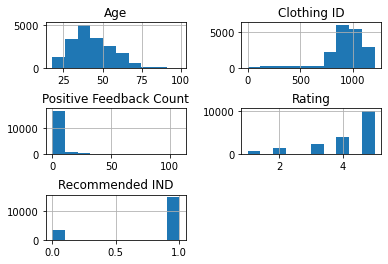

In [29]:
# histogramas de las variables numéricas
train_dataset.hist()
plt.subplots_adjust(hspace=0.9, wspace=0.4)
plt.show();

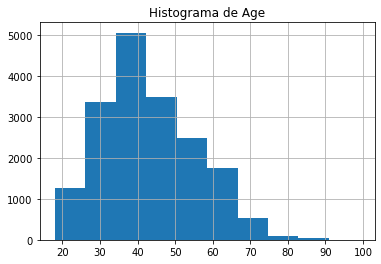

In [30]:
train_dataset["Age"].hist()
plt.title("Histograma de Age");

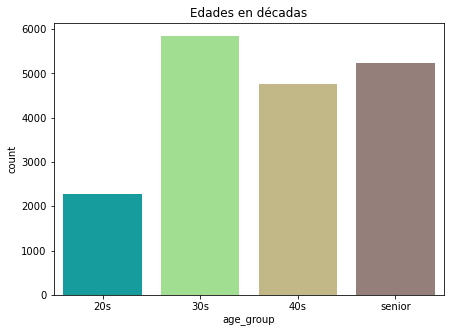

In [195]:
# Gráfica: Reparto de edades en grupos por décadas
plt.figure(figsize=(7,5))
sns.countplot(train_dataset['age_group'], palette="terrain")
plt.title("Edades en décadas");

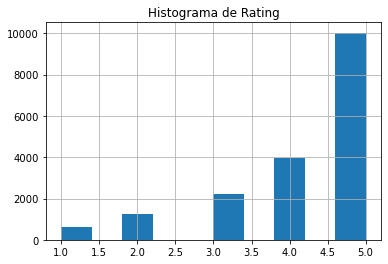

In [32]:
train_dataset["Rating"].hist()
plt.title("Histograma de Rating");

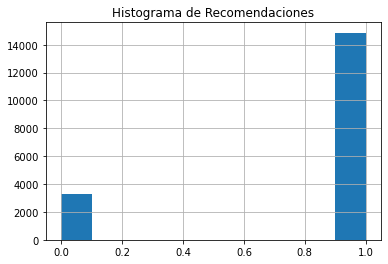

In [33]:
train_dataset["Recommended IND"].hist()
plt.title("Histograma de Recomendaciones");

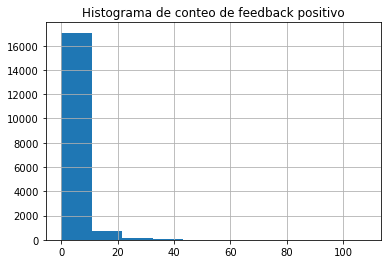

In [34]:
train_dataset["Positive Feedback Count"].hist()
plt.title("Histograma de conteo de feedback positivo");

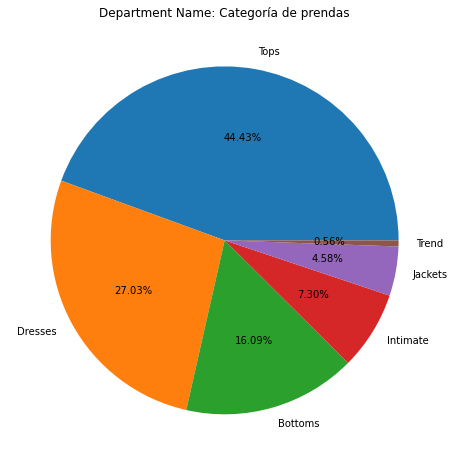

In [206]:
# Gráfica: Categorías de prendas
departamentos=train_dataset["Department Name"].value_counts()
plt.figure(figsize=(8,8))
plt.pie(departamentos.values,
        labels=departamentos.index,
        autopct='%1.2f%%')
p=plt.gcf()
plt.title("Department Name: Categoría de prendas")
plt.show()

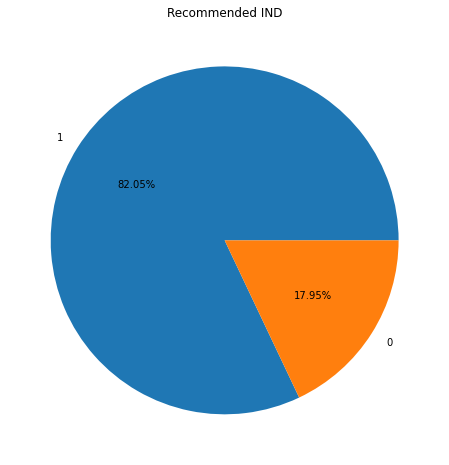

In [36]:
# Gráfica: Porcentaje de recomendaciones
departamentos=train_dataset["Recommended IND"].value_counts()
plt.figure(figsize=(8,8))
plt.pie(departamentos.values,
        labels=departamentos.index,
        autopct='%1.2f%%')
p=plt.gcf()
plt.title("Recommended IND")
plt.show()

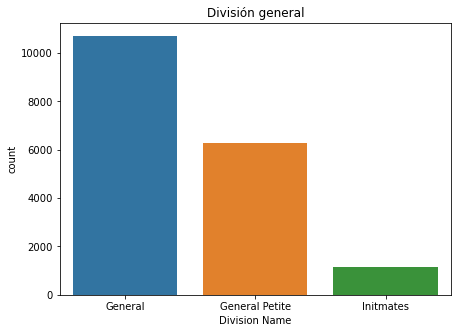

In [37]:
# Gráfica: División en grupos generales de tipos de prendas
plt.figure(figsize=(7,5))
sns.countplot(train_dataset['Division Name'].sort_values(ascending=True))
plt.title("División general");

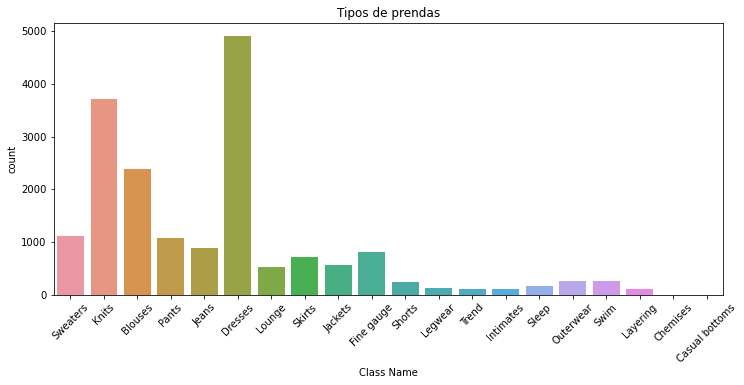

In [38]:
# gráfica: Tipos de prendas y su cantidad
plt.figure(figsize=(12,5))
sns.countplot(train_dataset['Class Name'])
plt.xticks(rotation=45)
plt.title("Tipos de prendas");

### Gráficas básicas bivariantes

Comenzando por una comparación 2 a 2 mediante un pairplot y siguiendo por las relaciones entre 2 variables que puedan aportar información para entender el comportamiento del cliente. Por ejemplo, cómo son las recomendaciones con respecto a los grupos de edad, qué prendas son mejor valoradas o cómo se relacionan recomendaciones y valoración del producto (rating). Finalmente, con una matriz de correlación, comprobaremos si hay relación directa proporcional (o inversa) entre dos variables.

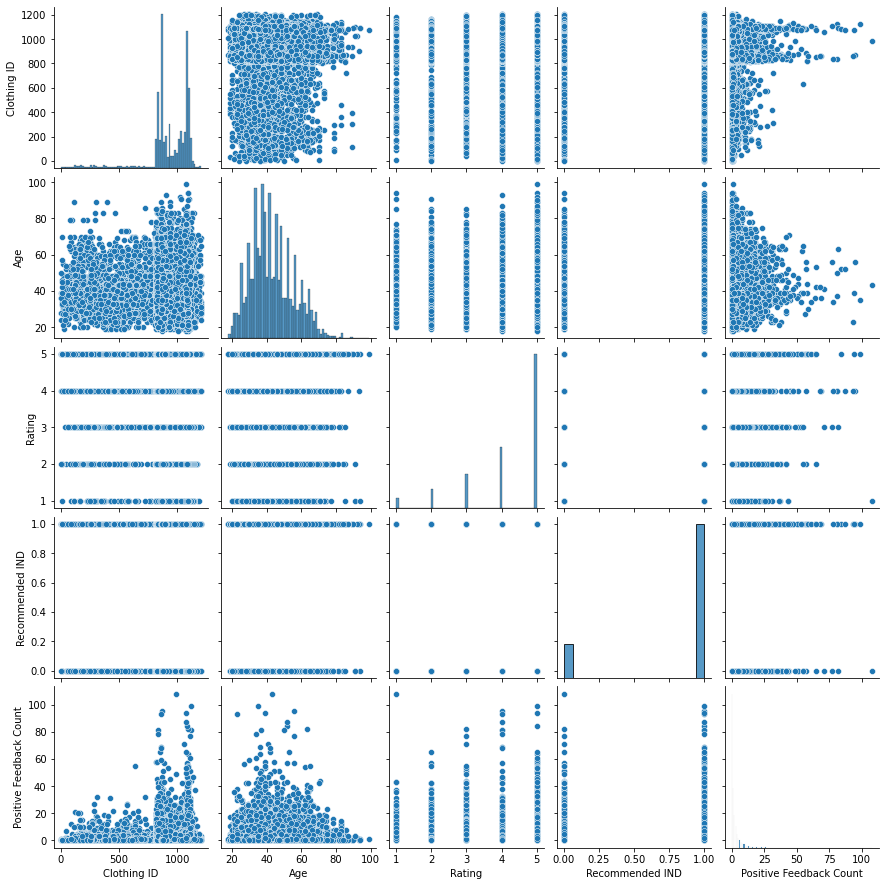

In [40]:
# gráfica: cuantitativas relacionadas 2 a 2 y sus histogramas
sns.pairplot(train_dataset);


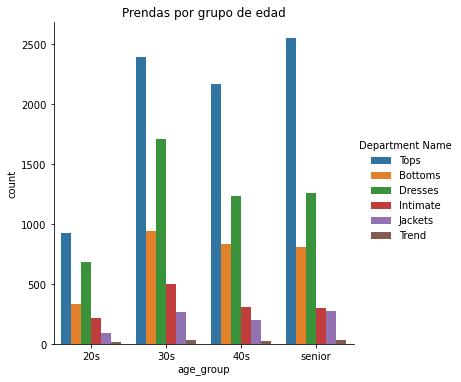

In [41]:
# Graf. Comentarios por tipo de prenda y grupo de edad
sns.catplot(data=train_dataset,
            x="age_group",  # si pinto en vertical 
           hue="Department Name",
           kind="count")
plt.title("Prendas por grupo de edad");

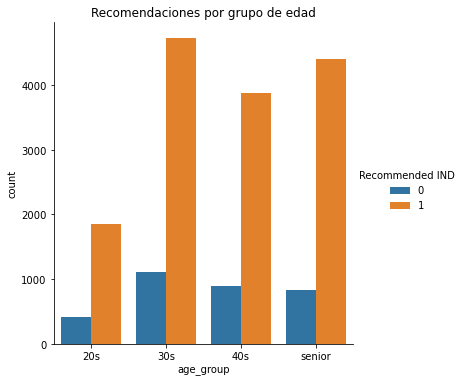

In [42]:
# Graf. Recomendaciones por grupo de edad
sns.catplot(data=train_dataset,
            x="age_group",  # si pinto en vertical 
            hue="Recommended IND",
            kind="count")
plt.title("Recomendaciones por grupo de edad");

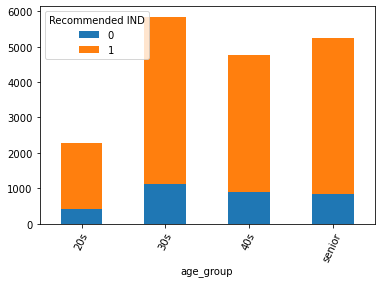

In [43]:
# Como el anterior, pero apilado
data=train_dataset.groupby(["age_group","Recommended IND"]).size().reset_index().pivot(columns='Recommended IND', index='age_group', values=0)

#data
data.plot(kind='bar', stacked=True)
plt.xticks(rotation=65);

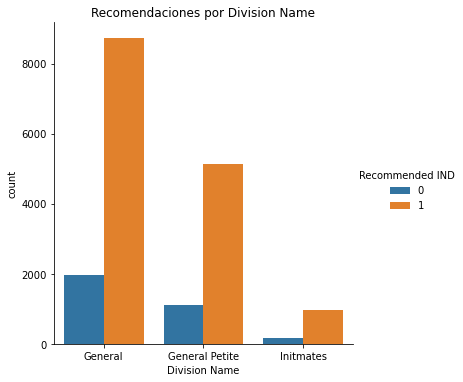

In [44]:
# Graf. Recomendaciones por categoría general
sns.catplot(data=train_dataset,
            x="Division Name",  # si pinto en vertical 
           hue="Recommended IND",
           kind="count")
plt.title("Recomendaciones por Division Name");

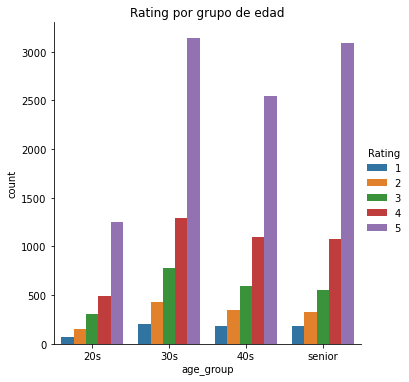

In [45]:
# Graf. Rating por grupo de edad
sns.catplot(data=train_dataset,
            x="age_group",  # si pinto en vertical 
           hue="Rating",
           kind="count")
plt.title("Rating por grupo de edad");

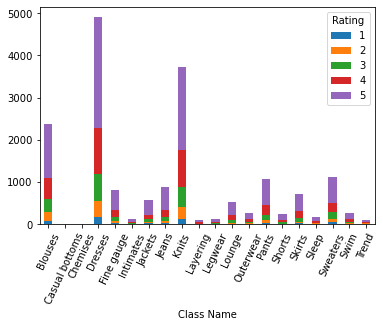

In [46]:
# Graf. ranking de categorías de prendas 

# preparo datos
data=train_dataset.groupby(["Class Name","Rating"]).size().reset_index().pivot(columns='Rating', index='Class Name', values=0)

#data
data.plot(kind='bar', stacked=True)
plt.xticks(rotation=65);

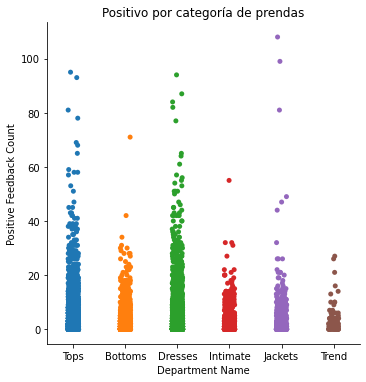

In [47]:
# Graf. Comentarios positivos por categoría de prendas
sns.catplot(data=train_dataset,
            x="Department Name",
            y="Positive Feedback Count")
plt.title("Positivo por categoría de prendas");

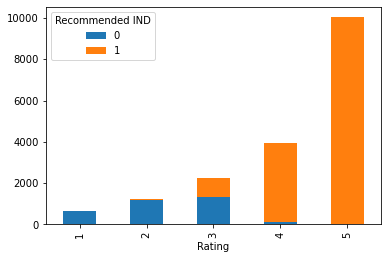

In [48]:
# gráfica: recomendaciones vs rating
df_plot = train_dataset.groupby(['Rating', 'Recommended IND']).size().reset_index().pivot(columns='Recommended IND', 
                                                                                  index='Rating', 
                                                                                  values=0)
df_plot.plot(kind='bar', stacked=True);

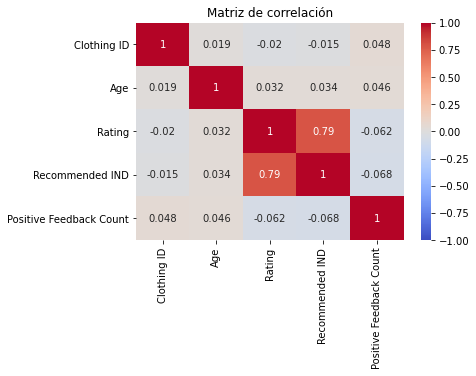

In [49]:
# gráfica: matriz de correlación
sns.heatmap(train_dataset.corr(),
           vmin=-1,
           vmax=1,
           annot=True,
           cmap = "coolwarm")
plt.title("Matriz de correlación");

## Conclusiones del análisis

1. **Las prendas**
Las prendas están categorizadas con tres distinciones: 
- "Division name", que diferencia entre prendas de talla standard, tallas pequeñas y ropa interior
- "Department name", categoría que engloba vestidos, ropa superior (tops), inferior (botons)...
- "Class name", sub-categoría con el tipo de prenda en sí: vestido, blusa, camiseta...

La categoría más popular son los tops y la prenda más mencionada los vestidos.

2. **Edades**
El rango va desde los 18 hasta los 99, aunque es de suponer que las edades más avanzadas son falsas, por lo que para facilitar el análisis de han hecho grupos de edades por décadas y a partir de 50 todas entran en el grupo "senior". El grupo más numeroso es el treintañero. 
Se puede observar las preferencias de cada década por una categoría de prenda. Los tops son los preferidos en todas las edades, sobre todo en 30 y senior. Los vestidos destacan entre las treintañeras.

3. **Recomendaciones y rating**
Las recomendaciones positivas superan abrumadoramente (82/18) a las negativas, siendo las principales recomendadoras las mujeres de 30, seguidas de las senior y las de 40. Las de 20 son bastante menos activas.
Como era de esperar, las prendas que obtienen 5 y 4 estrellas son recomendadas en su mayoría, las no recomendadas pertenecen a las estrellas 1 y 2. Con tres estrellas el procentaje de recomendación está equilibrado, aunque se inclina hacia la no recomendación.




## Toma de decisiones para el estudio de sentimientos con Machine Learning

**Desequilibrio de muestras**

El dataframe está muy desequilibrado hacia las recomendaciones positivas y el rating alto. ¿Debería equilibrarlo? Las opciones para ello serían reducir las recomendaciones positivas, añadir recomendaciones negativas sintéticas o hacer una combinación de ambos. Sin embargo, como el objetivo de este estudio es valorar los sentimientos de las recomendaciones y predecir la recomendación en función de este sentimiento, considero que no sería un problema dejarlo tal cual si a la hora de aplicar los modelos tengo en cuenta validaciones que compensen esta diferencia, como recall y matriz de confusión. 

Por esa razón decido no eliminar ni añadir registros, sino dejarlo tal cual está y controlar el resultado del entrenamiento con los scores.

**Selección del target**

En cuanto al target, podría elegir el rating o la recomendación. Escoger el rating implica transformar las estrellas:

- positivo: 5 y 4 estrellas
- neutro: 3 estrellas
- negativo: 2 y 1 estrellas

Tener un sentimiento neutro no me aporta nada, por lo que debería tratarlo de algún modo: ignorarlo y perder registros, asimilarlo a una de las otras categorías, añadiendoles error. 

Por esta razón decido utilizar como target para el estudio las recomendaciones. En los datos actuales recomendar tiene valor 1 y no recomendar, 0. Sin embargo, debido a que para una empresa aporta más valor conocer dónde están sus puntos de mejora, considero que es preferible cambiar la polaridad, de modo que el estudio se centre en detectar correctamente la falta de recomendación.


## Tratamiento de texto (reviews)

Comenzo el tratamiento de las columnas de texto. Para empezar, fundo en una única columna el comentario y su título. Los registros que no tienen dato de título ya no son un inconveniente.

Durante esta fase crearé nuevas columnas que me servirán principalmente para conocer mejor este texto. Sin embargo, para los modelos de Machine Learning, solo tendré en cuenta la columna con el texto tratado y las nuevas features que se generen automáticamente mediante los procesos de transformación.

En cuanto a las stopword, añadiré a la bolsa de palabras por defecto aquellas que tienen que ver con el tipo de prenda, ya que informan sobre el producto al que se refieren, pero no aportan información sentimental y aumentan innecesariamente el tamaño de los datos a procesar en el modelo.

In [17]:
# voy a unir las columnas Title y review text, para tratarlas como un único texto

train_dataset["Complete_text"]= train_dataset["Title"]+" "+train_dataset["Review Text"]
train_dataset["Complete_text"]=train_dataset["Complete_text"].fillna(train_dataset["Review Text"])

test_dataset["Complete_text"]= test_dataset["Title"]+" "+test_dataset["Review Text"]
test_dataset["Complete_text"]=test_dataset["Complete_text"].fillna(test_dataset["Review Text"])

In [53]:
test_dataset.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Complete_text
9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses,"Such a fun dress! I'm 5""5' and 125 lbs. i orde..."
11,1095,39,NaN,This dress is perfection! so pretty and flatte...,5,1,2,General Petite,Dresses,Dresses,This dress is perfection! so pretty and flatte...
13,767,44,Runs big,Bought the black xs to go under the larkspur m...,5,1,0,Initmates,Intimate,Intimates,Runs big Bought the black xs to go under the l...
16,1065,34,"You need to be at least average height, or taller",Material and color is nice. the leg opening i...,3,1,2,General,Bottoms,Pants,"You need to be at least average height, or tal..."
24,847,55,Versatile,"I love this shirt because when i first saw it,...",5,1,0,General,Tops,Blouses,Versatile I love this shirt because when i fir...


In [54]:
train_dataset.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,age_group,Complete_text
13365,948,24,Stunning!,This sweater is so beautiful on. it is thick m...,5,1,4,General,Tops,Sweaters,20s,Stunning! This sweater is so beautiful on. it ...
19834,875,63,NaN,This piece is almost what i want... i tried on...,4,1,38,General,Tops,Knits,senior,This piece is almost what i want... i tried on...
18722,829,42,Nice blouse,Really like this blouse but am returning for a...,4,1,0,General,Tops,Blouses,40s,Nice blouse Really like this blouse but am ret...
10635,1068,39,Perfect summer pants,These are the perfect light weight relaxing su...,5,1,0,General Petite,Bottoms,Pants,30s,Perfect summer pants These are the perfect lig...
7348,1030,44,Terrible cut,These look nothing like the picture! they are ...,2,1,4,General,Bottoms,Jeans,40s,Terrible cut These look nothing like the pictu...


In [18]:
# veo unos ejemplos de texto en la columna con 3 estrellas para ver cómo son los comentarios, tanto + como -
train_dataset[train_dataset["Rating"]==3]["Complete_text"]

5719     Huge! I really liked this top when i saw it on...
14774    Cute but very tight These run small. i normall...
670      Cute but didn't work for me :( I really wanted...
20001    Cute but not comfortable I was wondering wheth...
21702    Comfy but see through I ordered these on sale ...
                               ...                        
8482     Great quality I bought this top in black n mos...
20735    Not worth the price I got this shirt in stores...
14294    Love the top, but... Bought this early in the ...
12893    This one falls short Saw this tunic on line an...
18932    Did not love the fabric... I have a dress very...
Name: Complete_text, Length: 2241, dtype: object

In [19]:
train_dataset.loc[8358]["Complete_text"]

'Fraying after 2 wears! I loved these pants.they are so comfortable. however, after just wearing them twice, the threads of the leaves are fraying, and leaving lint on whatever i sit on. the leaves at the seat of the pants are now slowly disappearing. this after wearing twice to work! i imagine after a few more wears that the leaves at the seat of the pants will be close to gone, or at least much less "white" with threads then the rest of the places. this is super unfortunate and will be returning. too bad, they were l'

In [20]:
# Cuento los caracteres que hay en cada review (texto + título)
train_dataset["num_caract"]= train_dataset['Complete_text'].apply(len)
test_dataset["num_caract"]= test_dataset['Complete_text'].apply(len)
train_dataset

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,age_group,Complete_text,num_caract
13365,948,24,Stunning!,This sweater is so beautiful on. it is thick m...,5,1,4,General,Tops,Sweaters,20s,Stunning! This sweater is so beautiful on. it ...,384
19834,875,63,NaN,This piece is almost what i want... i tried on...,4,1,38,General,Tops,Knits,senior,This piece is almost what i want... i tried on...,500
18722,829,42,Nice blouse,Really like this blouse but am returning for a...,4,1,0,General,Tops,Blouses,40s,Nice blouse Really like this blouse but am ret...,157
10635,1068,39,Perfect summer pants,These are the perfect light weight relaxing su...,5,1,0,General Petite,Bottoms,Pants,30s,Perfect summer pants These are the perfect lig...,521
7348,1030,44,Terrible cut,These look nothing like the picture! they are ...,2,1,4,General,Bottoms,Jeans,40s,Terrible cut These look nothing like the pictu...,398
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21840,1086,35,So soft,I really liked this dress. i agree with the ot...,5,1,3,General,Dresses,Dresses,30s,So soft I really liked this dress. i agree wit...,214
20042,1075,41,Midi dress,I ordered this in large since it was the last ...,5,1,0,General Petite,Dresses,Dresses,40s,Midi dress I ordered this in large since it wa...,507
13050,1037,46,Great pants,I was so excited to see that these were on sal...,5,1,0,General Petite,Bottoms,Jeans,40s,Great pants I was so excited to see that these...,433
22213,1078,39,Against the majority,Everyone else who reviewed felt the dress fit ...,5,1,2,General,Dresses,Dresses,30s,Against the majority Everyone else who reviewe...,521


In [91]:
#¿Cuántos caracteres hay de media?
train_dataset["num_caract"].describe()

count    18113.000000
mean       325.068238
std        147.343432
min         12.000000
25%        200.000000
50%        318.000000
75%        476.000000
max        554.000000
Name: num_caract, dtype: float64

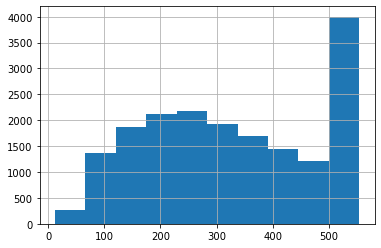

In [92]:
train_dataset["num_caract"].hist();

In [95]:
# Hay un pico en comentarios con más de 500 caracteres, ¿cuántos son realmente?
train_dataset["Recommended IND"][train_dataset["num_caract"]>500].count()

3842

In [97]:
train_dataset["Department Name"].unique()

array(['Tops', 'Bottoms', 'Dresses', 'Intimate', 'Jackets', 'Trend'],
      dtype=object)

In [99]:
train_dataset["Class Name"].unique()

array(['Sweaters', 'Knits', 'Blouses', 'Pants', 'Jeans', 'Dresses',
       'Lounge', 'Skirts', 'Jackets', 'Fine gauge', 'Shorts', 'Legwear',
       'Trend', 'Intimates', 'Sleep', 'Outerwear', 'Swim', 'Layering',
       'Chemises', 'Casual bottoms'], dtype=object)

In [21]:
# para completar las palabras de corte, creo una lista con los tipos de las prendas en plural y singular

prendas=list(train_dataset["Class Name"].unique())
prendas.pop(-2)  #borro nan
departamento=list(train_dataset["Department Name"].unique())

for dep in departamento:
    if dep not in prendas:
        prendas.append(dep)
    

prendas = [item.lower() for item in prendas]
print(prendas)

prendas_sing=['sweater', 'knit', 'blouse', 'pant', 'jean', 'dress', 
              'skirt', 'jacket', 'short', 'intimate', 'bottom', 'top']

for sing in prendas_sing:
    prendas.append(sing)


prendas

['sweaters', 'knits', 'blouses', 'pants', 'jeans', 'dresses', 'lounge', 'skirts', 'jackets', 'fine gauge', 'shorts', 'legwear', 'trend', 'intimates', 'sleep', 'outerwear', 'swim', 'layering', 'casual bottoms', 'tops', 'bottoms', 'intimate']


['sweaters',
 'knits',
 'blouses',
 'pants',
 'jeans',
 'dresses',
 'lounge',
 'skirts',
 'jackets',
 'fine gauge',
 'shorts',
 'legwear',
 'trend',
 'intimates',
 'sleep',
 'outerwear',
 'swim',
 'layering',
 'casual bottoms',
 'tops',
 'bottoms',
 'intimate',
 'sweater',
 'knit',
 'blouse',
 'pant',
 'jean',
 'dress',
 'skirt',
 'jacket',
 'short',
 'intimate',
 'bottom',
 'top']

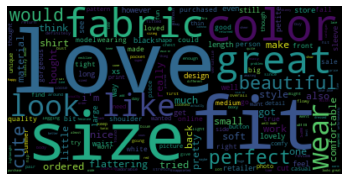

In [22]:
# Nube de palabras de las reviews en general

# stopword list:
mis_stopwords = set(stopwords.words('english'))
# añado las prendas
mis_stopwords.update(prendas)
texto = " ".join(review for review in train_dataset["Complete_text"])    
general_wordcloud = WordCloud(stopwords=mis_stopwords).generate(texto)

# gráfica
plt.imshow(general_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

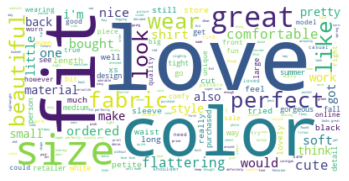

In [23]:
# Nube de palabras de las reviews que recomiendan el producto
train_recomiendan=train_dataset[train_dataset["Recommended IND"]==1]["Complete_text"]


texto = " ".join(review for review in train_recomiendan)    
recomiendan_wordcloud = WordCloud(background_color="white",stopwords=mis_stopwords).generate(texto)

# gráfica
plt.imshow(recomiendan_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



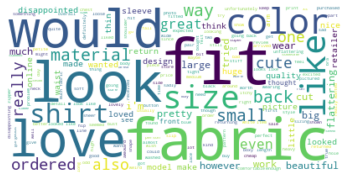

In [24]:
# Nube de palabras de las reviews que no recomiendan el producto
train_no_recomiendan=train_dataset[train_dataset["Recommended IND"]==0]["Complete_text"]


texto = " ".join(review for review in train_no_recomiendan)    
no_recomiendan_wordcloud = WordCloud(background_color="white",stopwords=mis_stopwords).generate(texto)

# gráfica
plt.imshow(no_recomiendan_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Algunas coclusiones hasta el momento
Observamos que en las nubes de palabras de recomendaciones y no recomendaciones aparecen sentimientos, prendas, calificativos...

Después de eliminar los singulares y plurales de las prendas y sus tipos, vemos que ya no se recomiendan los vestidos (ya lo sabíamos al analizar las prendas/recomendaciones) y los tops. Destaca "love" como sentimiento sobre otras como "perfect", "fit", "confortable"...
Algunas características que resaltan son el color y la talla.

En cuanto a los comentarios sin recomendación, también destaban "dress" y "top" como las prendas más nombradas antes de limpiar las stopwords.

Sentimientos positivos como "love" o "like" también aparecen destacados. Hay que recordar que este bloque se refiere a productos no recomendados, pero no necesariamente con calificación negativa.
Entre las características podemos ver de nuevo "size", "color" junto a "material" y muy destacado, "fabric".


Como vemos, es necesario ajustar más las stopwords para eliminar lo que no indique sentimiento, puesto que ambos ejemplos de nubes de palabras son muy similares y no dan información clara sobre su polaridad.


### Proceso de adecuación del texto

En los pasos previos, durante la nube de palabras, se eleminaron las stopwords que dificultaban la deteccion de sentimientos. También es necesario eliminar los signos de puntuación, caracteres especiales, números, etc como paso previo a otros tratamientos posteriores.

In [25]:
# voy a empezar el tratamiento del texto
import nltk
import re

# elimina o sustituye expresiones regulares (puntuación,saltos de linea...)

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

NO_SPACE = ""
SPACE = " "

# ponemos todo la review en minúsculas además
def preprocess_reviews(reviews):
    
    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in reviews]
    return reviews

train_dataset["clean_text"] = preprocess_reviews(train_dataset["Complete_text"])
test_dataset["clean_text"] = preprocess_reviews(test_dataset["Complete_text"])


In [124]:
# veo cómo va quedando
train_dataset["clean_text"]

13365    stunning this sweater is so beautiful on it is...
19834    this piece is almost what i want i tried on th...
18722    nice blouse really like this blouse but am ret...
10635    perfect summer pants these are the perfect lig...
7348     terrible cut these look nothing like the pictu...
                               ...                        
21840    so soft i really liked this dress i agree with...
20042    midi dress i ordered this in large since it wa...
13050    great pants i was so excited to see that these...
22213    against the majority everyone else who reviewe...
20494    looks like maternity wear first it's huge i'm ...
Name: clean_text, Length: 18113, dtype: object

In [ ]:
# Separo X/y para montar el modelo. Sobre ellos aplicaré distintas transformacines y modelos 
# para quedarme con el mejor

In [48]:
train_dataset["Recommended IND"]

13365    1
19834    1
18722    1
10635    1
7348     1
        ..
21840    1
20042    1
13050    1
22213    1
20494    0
Name: Recommended IND, Length: 18113, dtype: int64

In [54]:
# Cambio la polaridad del target, porque me interesa hacer foco en las "no recomendaciones", es decir, Recommended IND=0
# Creo nueva columna "Target" en la que 0 es recomienda y 1 no recomienda. De esta forma los scores encajan mejor

train_dataset["Target"]=train_dataset["Recommended IND"]
train_dataset["Target"]=train_dataset["Target"].map({0: 1, 1: 0})

test_dataset["Target"]=test_dataset["Recommended IND"]
test_dataset["Target"]=test_dataset["Target"].map({0: 1, 1: 0})

train_dataset["Target"]

13365    0
19834    0
18722    0
10635    0
7348     0
        ..
21840    0
20042    0
13050    0
22213    0
20494    1
Name: Target, Length: 18113, dtype: int64

In [55]:
# Ya tengo train y test separados, ahora tengo que obtener X_train, y_train, X_test, y_test
# me quedo solamente con "clean_text" en X y "Target"
X_train=np.array(train_dataset["clean_text"])
y_train=np.array(train_dataset["Target"])

X_test=np.array(test_dataset["clean_text"])
y_test=np.array(test_dataset["Target"])

In [27]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18113,)
(18113,)
(4528,)
(4528,)


### Procedimiento a seguir

Comienzo probando con una regresión logística a la que iré haciendo modificaciones (stemm,n_gram...) una a una de modo que pueda tener un modelo básico.

Después, sobre ese modelo inicial, montaré otros modelos sobre gridsearch para ajustar los parámetros con el objetivo de encontrar un modelo mejorado.


In [190]:
# función para comparar resultados de los modelos

def report(y_true, y_pred, labels):
    cm = pd.DataFrame(confusion_matrix(y_true=y_true, y_pred=y_pred), 
                                        index=labels, columns=labels)
    rep = classification_report(y_true=y_true, y_pred=y_pred)
    print(f'Confusion Matrix:\n{cm}\n\nClassification Report:\n{rep}')

In [85]:
# función con modelo básico (LogisticRegression) CON RECALL
def basic_model(X_TRAIN, X_TEST, y_TRAIN, y_TEST):
    
    X_train, X_val, y_train, y_val = train_test_split(X_TRAIN,
                                                      y_TRAIN,
                                                      train_size = 0.75,
                                                      random_state=42)



    best_c=0
    best_acc=0
    for c in [0.5, 1, 1.5, 2, 5]:

        lr = LogisticRegression(C=c)
        lr.fit(X_train, y_train)
        #print ("f1_score for C=%s: %s" % (c, f1_score(y_val, lr.predict(X_val))))
        if best_acc<recall_score(y_val, lr.predict(X_val)):
            best_acc=recall_score(y_val, lr.predict(X_val))
            best_c=c

    print()
    print("best c:",best_c)
    print("best_recall: ", round(best_acc,4))
    final_model = LogisticRegression(C=best_c)
    final_model.fit(X_TRAIN, y_TRAIN)

    print ("Test recall_score: %s" % round(recall_score(y_TEST, final_model.predict(X_TEST)),4))
    print()
    
    
    
    cm = pd.DataFrame(confusion_matrix(y_true=y_TEST, y_pred=final_model.predict(X_TEST)), 
                                        index=final_model.classes_, columns=final_model.classes_)
    rep = classification_report(y_true=y_TEST, y_pred=final_model.predict(X_TEST))
    print(f'Confusion Matrix:\n{cm}\n\nClassification Report:\n{rep}')



### Batería de pruebas del modelo básico y sus modificaciones

In [69]:
# PRUEBA 1. Básico con CountVectorizer + stop_words
# aplico CountVectorizer antes de ejecutar el modelo
cv=CountVectorizer(binary=True,
                  stop_words=mis_stopwords)

cv.fit(X_train)

X_1 = cv.transform(X_train)
X_test_1 = cv.transform(X_test)

# Ejecutar el modelo básico
basic_model(X_1, X_test_1,y_train, y_test)


best c: 2
best_f1:  0.6434
Test f1_score: 0.6207

Confusion Matrix:
      0    1
0  3487  192
1   322  527

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      3679
           1       0.73      0.62      0.67       849

    accuracy                           0.89      4528
   macro avg       0.82      0.78      0.80      4528
weighted avg       0.88      0.89      0.88      4528



In [75]:
X_1.shape

(18113, 14041)

In [70]:
# PRUEBA 2. Básico con CountVectorizer + stemmer

# Defino el stemmer
def get_stemmed_text(corpus):
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

# aplico stemmer a los 2 sets (train y test)
stemmed_train = get_stemmed_text(X_train)
stemmed_test = get_stemmed_text(X_test)

# ahora entrenamos el modelo
cv = CountVectorizer(binary=True)

cv.fit(stemmed_train)
X_stem = cv.transform(stemmed_train)
X_stem_test = cv.transform(stemmed_test)

# ejecuto el modelo básico
basic_model(X_stem, X_stem_test,y_train, y_test)


best c: 1.5
best_f1:  0.663
Test f1_score: 0.6525

Confusion Matrix:
      0    1
0  3500  179
1   295  554

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      3679
           1       0.76      0.65      0.70       849

    accuracy                           0.90      4528
   macro avg       0.84      0.80      0.82      4528
weighted avg       0.89      0.90      0.89      4528



In [76]:
X_stem.shape

(18113, 10443)

In [71]:
# PRUEBA 3. Básico con CountVectorizer + lemmatizer

# defino la lemmatización
def get_lemmatized_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

# Lematizamos las reviews
lemm_train = get_lemmatized_text(X_train)
lemm_test = get_lemmatized_text(X_test)

# Vectorizamos con conteo tras lematizar
cv = CountVectorizer(binary=True)

cv.fit(lemm_train)
X_lemm = cv.transform(lemm_train)
X_lemm_test = cv.transform(lemm_test)

# ejecuto el modelo básico
basic_model(X_lemm, X_lemm_test,y_train, y_test)


best c: 1.5
best_f1:  0.6569
Test f1_score: 0.6502

Confusion Matrix:
      0    1
0  3492  187
1   297  552

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      3679
           1       0.75      0.65      0.70       849

    accuracy                           0.89      4528
   macro avg       0.83      0.80      0.82      4528
weighted avg       0.89      0.89      0.89      4528



In [77]:
X_lemm.shape

(18113, 12989)

In [72]:
# PRUEBA 4. Básico con CountVectorizer + n-gram (bigram + trigram)


ngram_vectorizer=CountVectorizer(binary=True,
                                 ngram_range=(1,3))

ngram_vectorizer.fit(X_train)

X_ng = ngram_vectorizer.transform(X_train)
X_ng_test = ngram_vectorizer.transform(X_test)

basic_model(X_ng, X_ng_test,y_train, y_test)


best c: 1.5
best_f1:  0.6532
Test f1_score: 0.6584

Confusion Matrix:
      0    1
0  3539  140
1   290  559

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3679
           1       0.80      0.66      0.72       849

    accuracy                           0.91      4528
   macro avg       0.86      0.81      0.83      4528
weighted avg       0.90      0.91      0.90      4528



In [78]:
X_ng.shape

(18113, 772779)

In [80]:
# PRUEBA 5. Básico con TF-IDF vectorizer (Equivalent to CountVectorizer followed by TfidfTransformer)

tfidf_vectorizer=TfidfVectorizer()


tfidf_vectorizer.fit(X_train)
X_tf = tfidf_vectorizer.transform(X_train)
X_tf_test = tfidf_vectorizer.transform(X_test)


basic_model(X_tf, X_tf_test,y_train, y_test)


best c: 5
best_f1:  0.6238
Test f1_score: 0.6466

Confusion Matrix:
      0    1
0  3550  129
1   300  549

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3679
           1       0.81      0.65      0.72       849

    accuracy                           0.91      4528
   macro avg       0.87      0.81      0.83      4528
weighted avg       0.90      0.91      0.90      4528



In [81]:
X_tf.shape

(18113, 14211)

In [82]:
# PRUEBA 6. Básico con TF-IDF vectorizer + n-gram (bigram + trigram)+stopwords

tfidf_vectorizer_plus=TfidfVectorizer(analyzer = 'word',
                                     stop_words=mis_stopwords,
                                     ngram_range=(1,3))


tfidf_vectorizer_plus.fit(X_train)
X_tf_plus = tfidf_vectorizer_plus.transform(X_train)
X_tf_test_plus = tfidf_vectorizer_plus.transform(X_test)


basic_model(X_tf_plus, X_tf_test_plus,y_train, y_test)





best c: 5
best_f1:  0.3958
Test f1_score: 0.6207

Confusion Matrix:
      0    1
0  3547  132
1   322  527

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3679
           1       0.80      0.62      0.70       849

    accuracy                           0.90      4528
   macro avg       0.86      0.79      0.82      4528
weighted avg       0.89      0.90      0.89      4528



In [83]:
X_tf_plus.shape

(18113, 670002)

In [102]:
# PRUEBA 7. Prueba 4 + VarianceThreshold

# utilizo X_ng y X_ng_test de la prueba 4 y dejo todas las features que tengan una varianza superior a 0.0005
vth=VarianceThreshold(0.0005)
vth.fit(X_ng)
X_ng_vth=vth.transform(X_ng)
X_ng_vth_test=vth.transform(X_ng_test)


basic_model(X_ng_vth, X_ng_vth_test,y_train, y_test)


best c: 1.5
best_recall:  0.6826
Test recall_score: 0.6702

Confusion Matrix:
      0    1
0  3493  186
1   280  569

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3679
           1       0.75      0.67      0.71       849

    accuracy                           0.90      4528
   macro avg       0.84      0.81      0.82      4528
weighted avg       0.89      0.90      0.89      4528



In [103]:
X_ng_vth.shape

(18113, 25991)

In [118]:
# PRUEBA 8. Prueba 4 + ANOVA (SelectKBest)

# utilizo X_ng y X_ng_test de la prueba 4 y dejo 70.000 features
kbst=SelectKBest(k=70000)
kbst.fit(X_ng,y_train)
X_ng_kbst=kbst.transform(X_ng)
X_ng_kbst_test=kbst.transform(X_ng_test)


basic_model(X_ng_kbst, X_ng_kbst_test,y_train, y_test)


best c: 0.5
best_recall:  0.6164
Test recall_score: 0.5701

Confusion Matrix:
      0    1
0  3585   94
1   365  484

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3679
           1       0.84      0.57      0.68       849

    accuracy                           0.90      4528
   macro avg       0.87      0.77      0.81      4528
weighted avg       0.89      0.90      0.89      4528



In [119]:
X_ng_kbst.shape

(18113, 70000)

In [124]:
# PRUEBA 9. Prueba 4 + StandardScaler

# utilizo X_ng y X_ng_test de la prueba 4 y estandarizo
scler=StandardScaler(with_mean=False)
scler.fit(X_ng)
X_ng_scler=scler.transform(X_ng)
X_ng_scler_test=scler.transform(X_ng_test)


basic_model(X_ng_scler, X_ng_scler_test,y_train, y_test)



best c: 5
best_recall:  0.0172
Test recall_score: 0.0742

Confusion Matrix:
      0   1
0  3667  12
1   786  63

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      3679
           1       0.84      0.07      0.14       849

    accuracy                           0.82      4528
   macro avg       0.83      0.54      0.52      4528
weighted avg       0.83      0.82      0.76      4528



In [125]:
X_ng_scler.shape

(18113, 772779)

In [128]:
# PRUEBA 10. Básico con CountVectorizer + stop_words + stemmer + n-gram

# aplico CountVectorizer con todas las opciones antes de ejecutar el modelo

# Ya tenía definido en prueba 2 un stemmer que había aplicado a train y test: stemmed_train, stemmed_test

# ahora entrenamos el modelo
cv_stp_ng = CountVectorizer(binary=True,
                    stop_words=mis_stopwords,
                    ngram_range=(1,3))

cv_stp_ng.fit(stemmed_train)
X_stp_ng = cv_stp_ng.transform(stemmed_train)
X_stp_ng_test = cv_stp_ng.transform(stemmed_test)

# ejecuto el modelo básico
basic_model(X_stp_ng, X_stp_ng_test,y_train, y_test)



best c: 5
best_recall:  0.6275
Test recall_score: 0.6349

Confusion Matrix:
      0    1
0  3537  142
1   310  539

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3679
           1       0.79      0.63      0.70       849

    accuracy                           0.90      4528
   macro avg       0.86      0.80      0.82      4528
weighted avg       0.90      0.90      0.90      4528



'\nvth=VarianceThreshold(0.0005)\nvth.fit(X_stp_ng)\nX_stp_ng_vth=vth.transform(X_stp_ng)\nX_stp_ng_vth_test=vth.transform(X_stp_ng_test)\n\n\nbasic_model(X_stp_ng_vth, X_stp_ng_vth_test,y_train, y_test)\n\n'

### Conclusiones sobre el modelo básico
De las pruebas realizadas con regresión logística, la combinación que mejor resultado ha dado ha sido la prueba 7: LogisticRegression con CountVectorizer, n-gram (bigram + trigram), VarianceThreshold(0.0005) 
y un total de 25.991 features.

La elección de este modelo se ha basado en los resultados de recall y la matriz de confusión teniendo como objetivo la clasifiación correcta de nuestros 1 (no recomendado) para evitar que resulten como falsos negativos (es decir, que parezcan recomendaciones de producto cuando en realidad no lo son).

### Pruebas con otros modelos y ajuste de features

Además de regresión logística, voy a probar con árboles de decisión y SVM de clasificación. Para ello, utilizaré pipelines que encadenen el preprocesamiento del texto y gridsearch para ajustar los parámetros.

In [ ]:
# Probamos otros modelos, como SVM o árboles
# Creo un grid para que escoja el mejor entre ellos

In [138]:
# 1. preparo los modelos

rand_forest = Pipeline([("vect",CountVectorizer(),
                         "vth",VarianceThreshold()),
                         ("rf",RandomForestClassifier())
                       ])



svm = Pipeline([("vect",CountVectorizer(),
                 "vth",VarianceThreshold()),
                ("svm",SVC())
               ])


reg_log = Pipeline([("vect",CountVectorizer(),
                     "vth",VarianceThreshold()),
                    ("reglog",LogisticRegression())
                   ])



In [139]:
# 2. preparo sus parámetros

grid_random_forest = {
                    "vect__binary": [True],
                    "vect__ngram_range": [1,3],
                    'vth__threshold': [0.0005],   # el que mejor funcionaba en el modelo 7
                     "rf__n_estimators": [120,200],
                     "rf__max_depth": [3,4,5,6,10,15,17],
                     "rf__max_features": ["sqrt", 3, 4]                          
                     }






svm_param = {                    
            "vect__binary": [True],
            "vect__ngram_range": [1,3],
            'vth__threshold': [0.0005],   # el que mejor funcionaba en el modelo 7
            'svm__C': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
            'svm__kernel': ["linear","poly","rbf"],
            'svm__coef0': [-10.,-1., 0., 0.1, 0.5, 1, 10, 100],
            'svm__gamma': ('scale', 'auto')
            }


reg_log_param = {    
                 "vect__binary": [True],
                 "vect__ngram_range": [1,3],
                 'vth__threshold': [0.0005],   # el que mejor funcionaba en el modelo 7
                 "reglog__penalty": ["l1","l2"], 
                 "reglog__C": np.logspace(0, 4, 10)
                }



In [142]:
# 3. Entrenamos los modelos elegidos

# Almaceno en una lista de tuplas los modelos (nombre que le pongo, el modelo, hiperparametros)
models = [('rand_forest', rand_forest, grid_random_forest),
         ('svm', svm, svm_param),
         ('reg_log', reg_log, reg_log_param)]

# Declaro en un diccionario los pipelines e hiperparametros

models_gridsearch = {}

for i in models:
    models_gridsearch[i[0]] = GridSearchCV(i[1],
                                           i[2],
                                           cv=10,
                                           scoring="recall",
                                           verbose=1,
                                           n_jobs=-1)
    models_gridsearch[i[0]].fit(X_train, y_train)


Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: dictionary update sequence element #0 has length 4; 2 is required

In [192]:
# OTRA FORMA
# A. preparo grid de RandomForestClassifier ------

rand_forest = Pipeline(steps=[("vect",CountVectorizer()),
                         ("vth",VarianceThreshold()),
                         ("rf",RandomForestClassifier())
                       ])
grid_random_forest = {
                    "vect__binary": [True],
                    "vect__ngram_range": [(1,3)],
                    'vth__threshold': [0.0005],   # el que mejor funcionaba en el modelo 7
                     "rf__n_estimators": [120,200],
                     "rf__max_depth": [3,4,5,6,10,15,17],
                     "rf__max_features": ["sqrt", 3, 4]                          
                     }

gs_rf=GridSearchCV(rand_forest,
                        grid_random_forest,
                        cv=10,
                        scoring="recall",
                        n_jobs=-1,
                        verbose=1)  

# Grid de SVC  ---------
svm = Pipeline(steps=[("vect",CountVectorizer()),
                 ("vth",VarianceThreshold()),
                ("svm",SVC())
               ])
svm_param = {                    
            "vect__binary": [True],
            "vect__ngram_range": [(1,3)],
            'vth__threshold': [0.0005],   # el que mejor funcionaba en el modelo 7
            #'svm__C': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
            'svm__C': [0.5,1],
            'svm__kernel': ["linear"],
            'svm__coef0': [0.1, 1],
            #'svm__gamma': ('scale', 'auto')
            }
gs_svm=GridSearchCV(svm,
                    svm_param,
                    cv=10,
                    scoring="recall",
                    n_jobs=-1,
                    verbose=1)  

# Grid de LogisticRegression  ---------
reg_log = Pipeline(steps=[("vect",CountVectorizer()),
                     ("vth",VarianceThreshold()),
                    ("reglog",LogisticRegression())
                   ])

reg_log_param = {    
                 "vect__binary": [True],
                 "vect__ngram_range": [(1,3)],
                 'vth__threshold': [0.0005],   # el que mejor funcionaba en el modelo 7
                 "reglog__penalty": ["l1","l2"], 
                 "reglog__C": [1,1.5,3,5]
                }

gs_reg_log=GridSearchCV(reg_log,
                        reg_log_param,
                        cv=10,
                        scoring="recall",
                        n_jobs=-1,
                        verbose=1)  


# metemos en un dict los grid para luego meterlos en un bucle y entrenarlos.
grids={
    "gs_reg_log":gs_reg_log,
    "gs_svm":gs_svm,
    "gs_rf":gs_rf
}

'''
rnd_clf = RandomForestClassifier()

parameters = {'n_estimators': [10, 50, 100],
             'max_features': np.arange(3)}

grid_RF = GridSearchCV(rnd_clf, parameters, scoring='accuracy', cv = 10)

grid_RF.fit(X_train, y_train)


'''
print()

In [165]:
# ejecuto de 1 en 1: RandomForestClassifier
gs_rf.fit(X_train, y_train)

print("best score:", gs_rf.best_score_)
print("params:", gs_rf.best_params_)

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 21.6min finished


0.03228409627182634
{'rf__max_depth': 17, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200, 'vect__binary': True, 'vect__ngram_range': (1, 3), 'vth__threshold': 0.0005}


In [193]:
# ejecuto de 1 en 1: SVC  ------ NO EJECUTAR: MÁS DE 12H
%time
gs_svm.fit(X_train, y_train)

print("best score:",gs_svm.best_score_)
print("params:", gs_svm.best_params_)

CPU times: user 5 µs, sys: 7 µs, total: 12 µs
Wall time: 33.6 µs
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
# ejecuto 

In [168]:
# ejecuto de 1 en 1: LogisticRegression
%time
gs_reg_log.fit(X_train, y_train)

print("best score:", gs_reg_log.best_score_)
print("params:", gs_reg_log.best_params_)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  4.4min finished


best score: 0.6949523360075507
params: {'reglog__C': 5, 'reglog__penalty': 'l2', 'vect__binary': True, 'vect__ngram_range': (1, 3), 'vth__threshold': 0.0005}


In [164]:
# B. Ejecuto grid completo ----- NO HACER TARDA HORAS
%time
for nombre, grid_search in grids.items():  #clave, valor del diccionario
    grid_search.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  9.2min finished


Fitting 10 folds for each of 384 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 95.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 352.4min


KeyboardInterrupt: 

In [ ]:
#comparamos todos los grid y buscamos el mejor (lo ponemos en df ordenado)

best_grids=[(i,j.best_score_) for i ,j in grids.items()]
best_grids =pd.DataFrame(best_grids,columns=["Grid","Best Score"])
best_grids.sort_values(by="Best Score",ascending=False)

In [170]:
# resumen del best model
gs_reg_log.best_params_

{'reglog__C': 5,
 'reglog__penalty': 'l2',
 'vect__binary': True,
 'vect__ngram_range': (1, 3),
 'vth__threshold': 0.0005}

In [171]:
# predicción sobre test
estimator=gs_reg_log.best_estimator_
print("score: ", estimator.score(X_test,y_test))
estimator.predict(X_test)

score:  0.8937720848056537


array([0, 0, 0, ..., 1, 0, 0])

In [191]:
# estadísticos de test

report(y_true=y_test, y_pred=estimator.predict(X_test), labels=estimator.classes_)


Confusion Matrix:
      0    1
0  3481  198
1   283  566

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      3679
           1       0.74      0.67      0.70       849

    accuracy                           0.89      4528
   macro avg       0.83      0.81      0.82      4528
weighted avg       0.89      0.89      0.89      4528



### Best model

Como hemos visto, el modelo que mejor se comporta es de nuevo la regresión logística. Los árboles tenían peor respuesta de recall (cercano al 40%). Las diferentes pruebas realizadas sobre el modelo basado en SVM han sido imposibles de ejecutar por cuestiones de tiempo de computación. A pesar de reducir al conjunto de parámetros, pasadas 12 horas el modelo no había completado ni 1/4 del procesamiento, por lo que se ha desestimado.
Finalmente se ha escogido el best_model de la regresión logística, ya que aunque es practicamente igual que el obtenido de forma manual, tiene algunos parámetros más que no se turvieron en cuenta durante el entrenamiento básico.

Es hora de comenzar las predicciones. Tomo una muestra de test y compruebo la bondad de la predicción. Después, creo 3 nuevas entradas de "review" que simulan un comentario positivo, uno negativo y otro difícil de clasificar. Para todos ellos realizo la predicción sobre si recomendarían o no el producto (recordando que la lógica es inversa: 1-No recomienda, 0-Sí recomienda).

In [180]:
X_test[21:22]

array(['pretry top perfect for work or going out i layered this with the reversible tank in medium pink so it would be work appropriate it did not feel scratchy to me maybe because i layered it great buy especially with the discounts feel like i lucked out'],
      dtype=object)

In [181]:
estimator.predict(X_test[21:22])

array([0])

In [183]:
malo=np.array(["This dress has disappointed me. It looked beautiful on the web, but it is very wide and the fabric looks like plastic"])

In [184]:
estimator.predict(malo)

array([1])

In [185]:
bueno=np.array(["These jeans are great for college or going out with friends. I love how they fit me"])

In [186]:
estimator.predict(bueno)

array([0])

In [187]:
regular=np.array(["I like the shape of this skirt, but it is a difficult color to match. I don't know if I'm going to be able to wear it a lot"])

In [188]:
estimator.predict(regular)

array([0])

## Conclusiones

A pesar de que el dataset tenía un marcado desequilibrio en el target, se ha conseguido un ratio de acierto (recall) para el target desfavorable ("no recomienda") del 67%, obteniendo el target mayoritario ("sí recomienda") un acierto del 95%.

El modelo que mejor respuesta ha ofrecido ha sido la regresión logística combinada con tratamiento de texto (vectorización, n-gram y reducción de features en función de la desviación típica).

Para este caso particular, la diferencia en el tratamiento del texto con lemmatizacion o con stemmer no ha sido significativa. Sin embargo, aplicar bigramas y trigramas sí ha resultado beneficioso.

En cuanto a la reducción de features, ha funcionado mucho mejor VarianThreshold que SelectKBest.